<a href="https://colab.research.google.com/github/nailathaya/CCI-Project-Computer-Vision/blob/main/Hard_Hat_(Safety_Helmet)_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Requirements.txt dari GitHub

In [ ]:
# install requirements.txt dari github
!pip install -r https://raw.githubusercontent.com/nailathaya/CCI-Project-Computer-Vision/main/requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 842.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 99.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

# Load Dataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/hard-hat-detection")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/hard-hat-detection


Classes:

- Helmet
- Person
- Head

# Konversi Format Dataset

Struktur data awal (dalam format Pascal VOC)

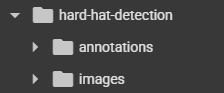

Struktur data setelah konversi (dalam format YOLO)

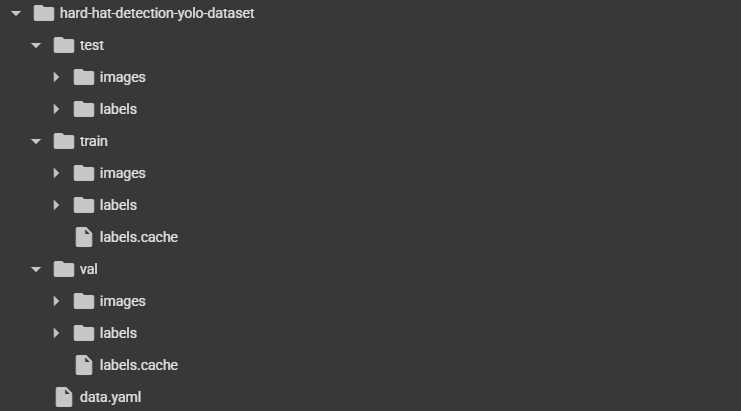

In [ ]:
import os
import random
import shutil
import xml.etree.ElementTree as ET
from tqdm import tqdm

In [ ]:
# Ubah format dataset jadi YOLO Format, karena dari kaggle formatnya Pascal VOC

voc_dir = "/kaggle/input/hard-hat-detection/annotations"
image_dir = "/kaggle/input/hard-hat-detection/images"
output_dir = "/content/hard-hat-detection-yolo-dataset"

class_names = ['helmet', 'head', 'person']
class_map = {name: idx for idx, name in enumerate(class_names)}

# Buat struktur folder YOLO per split
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(output_dir, split, 'images'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, split, 'labels'), exist_ok=True)

# === Fungsi konversi dari XML ke YOLO ===
def convert_xml_to_yolo(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    size = root.find('size')
    width = int(size.find('width').text)
    height = int(size.find('height').text)

    yolo_lines = []
    for obj in root.findall('object'):
        label = obj.find('name').text.strip()
        if label not in class_map:
            print(f"[Warning] Label tidak dikenali: {label}")
            continue
        class_id = class_map[label]

        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)

        x_center = (xmin + xmax) / 2 / width
        y_center = (ymin + ymax) / 2 / height
        box_width = (xmax - xmin) / width
        box_height = (ymax - ymin) / height

        yolo_lines.append(f"{class_id} {x_center:.6f} {y_center:.6f} {box_width:.6f} {box_height:.6f}")

    return yolo_lines

# === Kumpulkan pasangan XML + gambar ===
xml_files = [f for f in os.listdir(voc_dir) if f.endswith(".xml")]
pairs = []
for xml_file in xml_files:
    base = os.path.splitext(xml_file)[0]
    img_path = os.path.join(image_dir, base + ".png")
    if os.path.exists(img_path):
        pairs.append((xml_file, base + ".png"))

print(f"Total pasangan XML+image: {len(pairs)}")

# === Split 70/20/10 ===
random.seed(42)
random.shuffle(pairs)

n = len(pairs)
n_train = int(n * 0.7)
n_val = int(n * 0.2)

splits = {
    'train': pairs[:n_train],
    'val': pairs[n_train:n_train + n_val],
    'test': pairs[n_train + n_val:]
}

# === Proses per split ===
for split, items in splits.items():
    print(f"\nMemproses split {split} ({len(items)} data)...")
    for xml_file, img_file in tqdm(items):
        xml_path = os.path.join(voc_dir, xml_file)
        img_path = os.path.join(image_dir, img_file)
        base_name = os.path.splitext(img_file)[0]

        # Konversi anotasi
        yolo_lines = convert_xml_to_yolo(xml_path)

        # Simpan label
        label_path = os.path.join(output_dir, split, 'labels', base_name + ".txt")
        with open(label_path, 'w') as f:
            f.write("\n".join(yolo_lines))

        # Salin gambar
        dst_img = os.path.join(output_dir, split, 'images', img_file)
        shutil.copyfile(img_path, dst_img)

print("\n✅ Dataset selesai dikonversi dan dibagi.")

# === Buat file data.yaml ===
yaml_path = os.path.join(output_dir, "data.yaml")
with open(yaml_path, 'w') as f:
    f.write(f"""train: {os.path.join(output_dir, 'train/images')}
val: {os.path.join(output_dir, 'val/images')}
test: {os.path.join(output_dir, 'test/images')}

nc: {len(class_names)}
names: {class_names}
""")

print(f"📄 File data.yaml dibuat di: {yaml_path}")

Total pasangan XML+image: 5000

Memproses split train (3500 data)...


100%|██████████| 3500/3500 [00:33<00:00, 105.75it/s]



Memproses split val (1000 data)...


100%|██████████| 1000/1000 [00:09<00:00, 106.49it/s]



Memproses split test (500 data)...


100%|██████████| 500/500 [00:04<00:00, 102.83it/s]


✅ Dataset selesai dikonversi dan dibagi.
📄 File data.yaml dibuat di: /content/hard-hat-detection-yolo-dataset/data.yaml


In [ ]:
from ultralytics import YOLO

model = YOLO("yolov10m.pt")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 32.1M/32.1M [00:00<00:00, 64.1MB/s]


In [ ]:
train_results = model.train(
    data="/content/hard-hat-detection-yolo-dataset/data.yaml",
    epochs=10,
    imgsz=480,
    device = 0
)

Ultralytics 8.3.167 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/hard-hat-detection-yolo-dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=480, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov10m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, p

100%|██████████| 755k/755k [00:00<00:00, 36.0MB/s]

Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1     78720  ultralytics.nn.modules.block.SCDown          [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1    228672  ultralytics

 14                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 15             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 16                  -1  2    517632  ultralytics.nn.modules.block.C2f             [576, 192, 2]                 
 17                  -1  1    332160  ultralytics.nn.modules.conv.Conv             [192, 192, 3, 2]              
 18            [-1, 13]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 19                  -1  2    831744  ultralytics.nn.modules.block.C2fCIB          [576, 384, 2, True]           
 20                  -1  1    152448  ultralytics.nn.modules.block.SCDown          [384, 384, 3, 2]              
 21            [-1, 10]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 22                  -1  2   1911168  ultralytics.nn.modules.block.C2fCIB          [960,

100%|██████████| 5.35M/5.35M [00:00<00:00, 160MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2026.9±981.0 MB/s, size: 253.1 KB)


train: Scanning /content/hard-hat-detection-yolo-dataset/train/labels... 3500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3500/3500 [00:02<00:00, 1278.91it/s]


train: New cache created: /content/hard-hat-detection-yolo-dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1425.7±795.6 MB/s, size: 266.3 KB)


val: Scanning /content/hard-hat-detection-yolo-dataset/val/labels... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:02<00:00, 470.93it/s]

val: New cache created: /content/hard-hat-detection-yolo-dataset/val/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 129 weight(decay=0.0), 142 weight(decay=0.0005), 141 bias(decay=0.0)
Image sizes 480 train, 480 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      4.79G      3.135      3.583      2.572         64        480: 100%|██████████| 219/219 [01:31<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:13<00:00,  2.31it/s]


                   all       1000       5190      0.796      0.448       0.49      0.277

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      5.54G      3.189      2.322      2.609         58        480: 100%|██████████| 219/219 [01:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.57it/s]


                   all       1000       5190      0.816      0.404      0.459      0.245

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      5.61G      3.136      2.159      2.594         52        480: 100%|██████████| 219/219 [01:26<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.47it/s]


                   all       1000       5190      0.896      0.493      0.559      0.334

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      5.68G      3.023          2      2.525         48        480: 100%|██████████| 219/219 [01:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.46it/s]

                   all       1000       5190      0.879      0.504      0.554      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      5.77G      2.924      1.826      2.462         51        480: 100%|██████████| 219/219 [01:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.56it/s]


                   all       1000       5190      0.915       0.52      0.583      0.357

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      5.85G      2.848      1.689      2.426         40        480: 100%|██████████| 219/219 [01:26<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:13<00:00,  2.45it/s]

                   all       1000       5190      0.931      0.531      0.594      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      5.93G      2.764      1.592      2.376         39        480: 100%|██████████| 219/219 [01:26<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.51it/s]


                   all       1000       5190      0.934      0.558      0.613      0.383

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      5.99G      2.715      1.505       2.35         48        480: 100%|██████████| 219/219 [01:26<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.55it/s]

                   all       1000       5190      0.941      0.573      0.621      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      6.08G      2.663      1.418      2.316         42        480: 100%|██████████| 219/219 [01:26<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.48it/s]


                   all       1000       5190       0.95      0.574      0.625      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      6.16G      2.578      1.333      2.294         62        480: 100%|██████████| 219/219 [01:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:13<00:00,  2.46it/s]


                   all       1000       5190      0.945      0.578      0.627       0.41

10 epochs completed in 0.282 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 33.4MB
Optimizer stripped from runs/detect/train/weights/best.pt, 33.4MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.167 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10m summary (fused): 136 layers, 15,314,905 parameters, 0 gradients, 58.9 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.22it/s]


                   all       1000       5190      0.946      0.578      0.627       0.41
                helmet        916       3945      0.926      0.874      0.943      0.616
                  head        171       1096      0.911      0.859      0.921      0.606
                person         34        149          1          0     0.0173    0.00717
Speed: 0.2ms preprocess, 5.6ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/train
